In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy import optimize, stats


C:\Users\miche\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Patient of interest

In [2]:
# function to read in dataset 
def read_file(filename):
    df = pd.read_csv(filename)

    # Split the column into two new columns
    df[['TIMESTAMP', 'HRV']] = df['TIMESTAMP;HRV'].str.split(';', expand=True)

    # Convert TIMESTAMP & HRV to appropriate data types
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])
    df['HRV'] = pd.to_numeric(df['HRV'], errors='coerce')

    # Drop the original column
    df.drop(columns=['TIMESTAMP;HRV'], inplace=True)

    # Set TIMESTAMP as the index
    df.set_index('TIMESTAMP', inplace=True)

    return df

In [3]:
# read in patient one dataset
df_patient_hr = read_file('patient_hr_105.csv')
df_patient_hr

,HRV
TIMESTAMP,
2011-05-10 13:25:00.000,5000.00
2011-05-10 13:25:05.000,2000.00
2011-05-10 13:25:07.000,2000.00
2011-05-10 13:25:09.000,2000.00
2011-05-10 13:25:11.000,2000.00
...,...
2011-05-11 02:52:38.669,680.66
2011-05-11 02:52:39.350,684.57
2011-05-11 02:52:40.034,675.78


In [4]:
# check to make sure there are no null values
df_patient_hr.isnull().sum()

HRV    0
dtype: int64

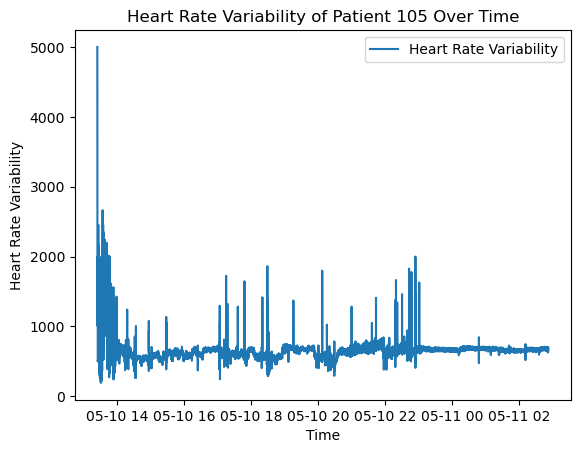

In [5]:
# visualize the time series
plt.plot(df_patient_hr['HRV'], label='Heart Rate Variability')
plt.xlabel('Time')
plt.ylabel('Heart Rate Variability')
plt.legend()
plt.title('Heart Rate Variability of Patient 105 Over Time')
plt.show();

In [6]:
# getting every 20 samples - downsampling because there are too many samples
df_downsampled = df_patient_hr.iloc[::20]
df_downsampled

,HRV
TIMESTAMP,
2011-05-10 13:25:00.000,5000.00
2011-05-10 13:25:41.378,2000.00
2011-05-10 13:26:07.851,860.35
2011-05-10 13:26:41.939,2000.00
2011-05-10 13:27:18.373,2000.00
...,...
2011-05-11 02:51:44.249,671.88
2011-05-11 02:51:57.503,635.74
2011-05-11 02:52:10.317,666.99


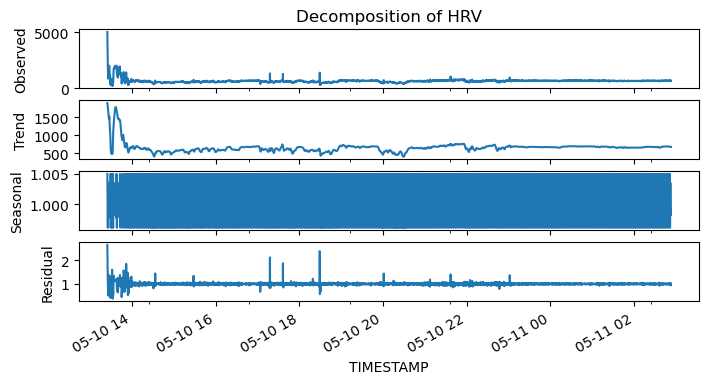

In [7]:
# checking out the decompositions

# setting the period makes the assumption that the seasonal trend should happen every "period" units (e.g. 10 years, or 5 days)
decomp1 = seasonal_decompose(df_downsampled['HRV'], period=10, model='multiplicative', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of HRV')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

- no patterns in residual

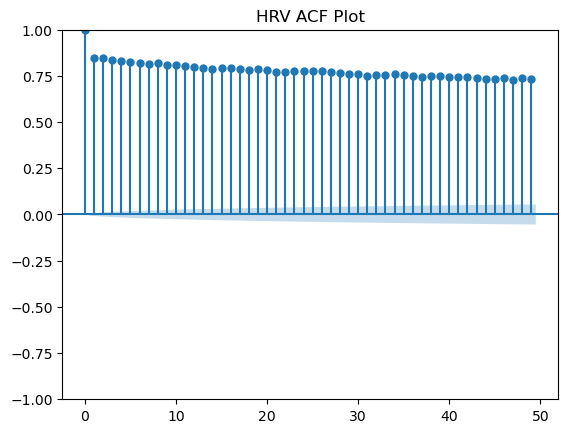

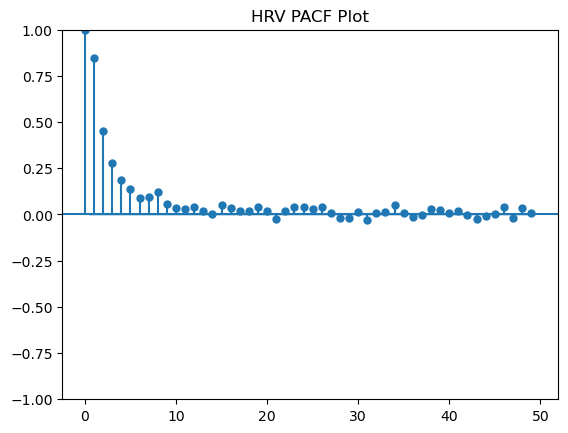

In [8]:
# plot of original dataset

# Autocorrelation Function
# This is used to determine the appropriate lag

series = df_patient_hr['HRV']
plot_acf(series, title = 'HRV ACF Plot')
plt.show();

# plot partial autocorrelation function (PACF)
plot_pacf(series, title = 'HRV PACF Plot')
plt.show();

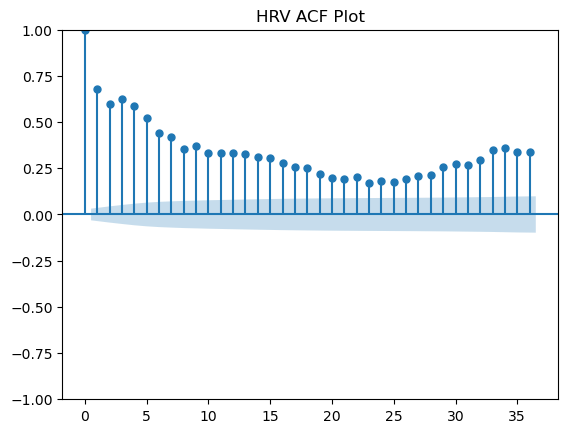

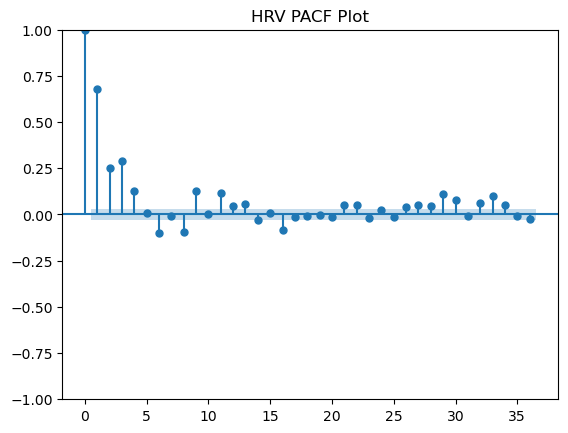

In [9]:
# plots of downsampled dataset

# Autocorrelation Function

series = df_downsampled['HRV']
plot_acf(series, title = 'HRV ACF Plot')
plt.show();

# plot partial autocorrelation function (PACF)
plot_pacf(series, title = 'HRV PACF Plot')
plt.show();

- AR model may be slightly better. This in the partial autocorrelation plot, it doesn't drop immediately.

# Create lag features for AR model

In [10]:
# create lag features 1-12
for i in range(1, 13):
    df_downsampled[f'Lag {i}'] = df_downsampled['HRV'].shift(i)

df_downsampled = df_downsampled.dropna()

df_downsampled.head()

,HRV,Lag 1,Lag 2,Lag 3,Lag 4,Lag 5,Lag 6,Lag 7,Lag 8,Lag 9,Lag 10,Lag 11,Lag 12
TIMESTAMP,,,,,,,,,,,,,
2011-05-10 13:30:07.569,507.81,456.05,296.88,914.06,477.54,1200.20,1013.67,2000.00,2000.00,2000.00,860.35,2000.00,5000.00
2011-05-10 13:30:20.212,528.32,507.81,456.05,296.88,914.06,477.54,1200.20,1013.67,2000.00,2000.00,2000.00,860.35,2000.00
2011-05-10 13:30:31.875,527.34,528.32,507.81,456.05,296.88,914.06,477.54,1200.20,1013.67,2000.00,2000.00,2000.00,860.35
2011-05-10 13:30:42.078,452.15,527.34,528.32,507.81,456.05,296.88,914.06,477.54,1200.20,1013.67,2000.00,2000.00,2000.00
2011-05-10 13:30:51.419,612.30,452.15,527.34,528.32,507.81,456.05,296.88,914.06,477.54,1200.20,1013.67,2000.00,2000.00


# Split data into training and testing set for AR model

In [11]:
# split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
train_size = int(.8 * len(df_downsampled))
train_data = df_downsampled[:train_size]
test_data = df_downsampled[train_size:]

# put the y feature in arrays
y_train = np.array(train_data['HRV']).reshape(-1,1)
y_test = np.array(test_data['HRV']).reshape(-1,1)

# AR Model

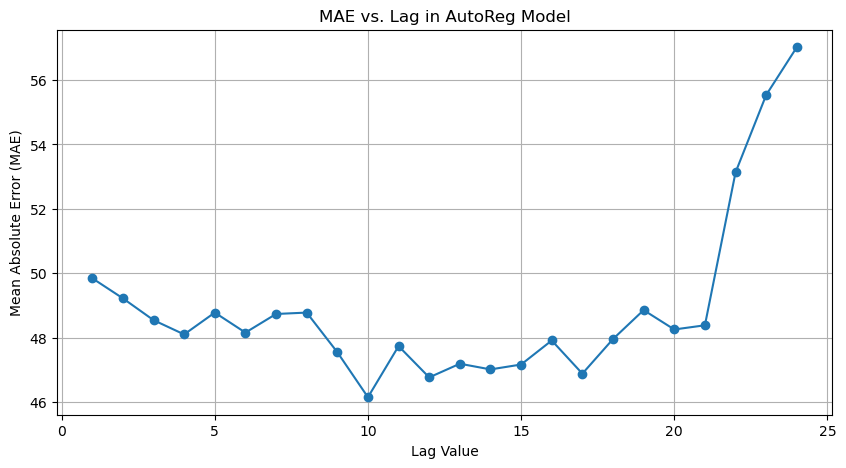

In [12]:
# define a range of lags to test
lag_values = range(1, 25)
mae_scores = []

# loop through different lag values
for lag in lag_values:
    ar_model = AutoReg(y_train, lags=lag, trend='c')
    ar_results = ar_model.fit()
    
    # make predictions
    pred_data = ar_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # compute MAE
    mae = mean_absolute_error(y_test, pred_data)
    mae_scores.append(mae)

# plolt MAE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(lag_values, mae_scores, marker='o', linestyle='-')
plt.xlabel("Lag Value")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Lag in AutoReg Model")
plt.grid(True)
plt.show()

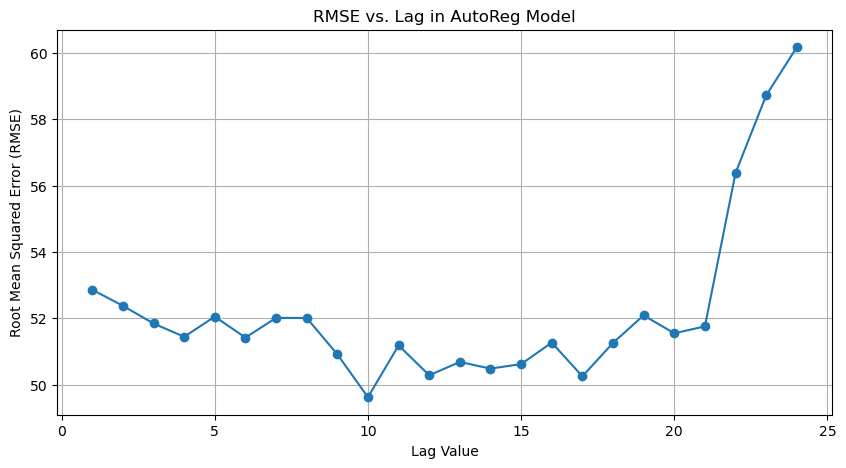

In [13]:
# define a range of lags to test
lag_values = range(1, 25)
rmse_scores = []

# loop through different lag values
for lag in lag_values:
    ar_model = AutoReg(y_train, lags=lag, trend='c')
    ar_results = ar_model.fit()
    
    # make predictions
    pred_data = ar_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
     
    # compute rmse
    rmse = np.sqrt(mean_squared_error(y_test, pred_data))
    rmse_scores.append(rmse)

# plot RMSE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(lag_values, rmse_scores, marker='o', linestyle='-')
plt.xlabel("Lag Value")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE vs. Lag in AutoReg Model")
plt.grid(True)
plt.show()

## Manually

In [14]:
# lag chosen
lag = 12

# define X train
X_train = train_data.drop(columns=["HRV"])
X_train = np.column_stack((np.ones(len(X_train)), X_train))

# fit the model using OLS
w = np.dot(np.linalg.inv(np.dot(X_train.T, X_train)), np.dot(X_train.T, y_train))
print("Model coefficients:", w)

# initialize predictions
y_pred = []
last_vals = np.array(train_data['HRV'].iloc[-lag:].values[::-1])

# add constant term to last_vals for prediction
last_vals_with_const = np.concatenate([[1], last_vals])

for i in range(len(y_test)):
    # predict next value
    next_val = np.dot(last_vals_with_const, w)
    y_pred.append(next_val)
    
    # update last_vals
    last_vals = np.roll(last_vals, 1)
    last_vals[0] = next_val
    last_vals_with_const = np.concatenate([[1], last_vals])

Model coefficients: [[ 4.61783838e+01]
 [ 4.86800923e-01]
 [ 2.08918345e-01]
 [ 2.08571328e-01]
 [ 9.86938343e-02]
 [-4.97908445e-02]
 [-7.74000701e-02]
 [ 4.32570416e-02]
 [-1.66889961e-01]
 [ 9.26292743e-02]
 [ 4.85570079e-02]
 [ 4.90585564e-03]
 [ 2.72436538e-02]]


In [15]:
# function to find the roots to look at stationary assumption
def find_ar_roots(ar_coeffs):
    # make sure ar_coeffs is 1D
    ar_coeffs_1d = ar_coeffs.flatten() if ar_coeffs.ndim > 1 else ar_coeffs
    
    # create the polynomial coefficients (note the negative sign for AR coeffs)
    poly_coeffs = np.concatenate([[1], -1 * ar_coeffs_1d])
    
    # find the roots
    roots = np.roots(poly_coeffs)
    
    return roots

# coefficients of the model
ar_coeffs = w[1:]

# roots of the model
roots = find_ar_roots(ar_coeffs)
print(abs(roots))

[0.96456223 0.8225951  0.8225951  0.8216801  0.8216801  0.82452528
 0.82452528 0.56796809 0.74642526 0.74642526 0.53607603 0.53607603]


In [16]:
# put predictions into a data frame for plotting purposes
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': y_pred})
pred_data.set_index('Time', inplace=True)
pred_data.head()

,pred HRV
Time,
2011-05-11 00:01:34.837,[662.8074578373559]
2011-05-11 00:01:47.940,[661.5885208555163]
2011-05-11 00:02:01.230,[661.8460216113122]
2011-05-11 00:02:14.396,[656.5035517136873]
2011-05-11 00:02:27.557,[654.9728541864836]


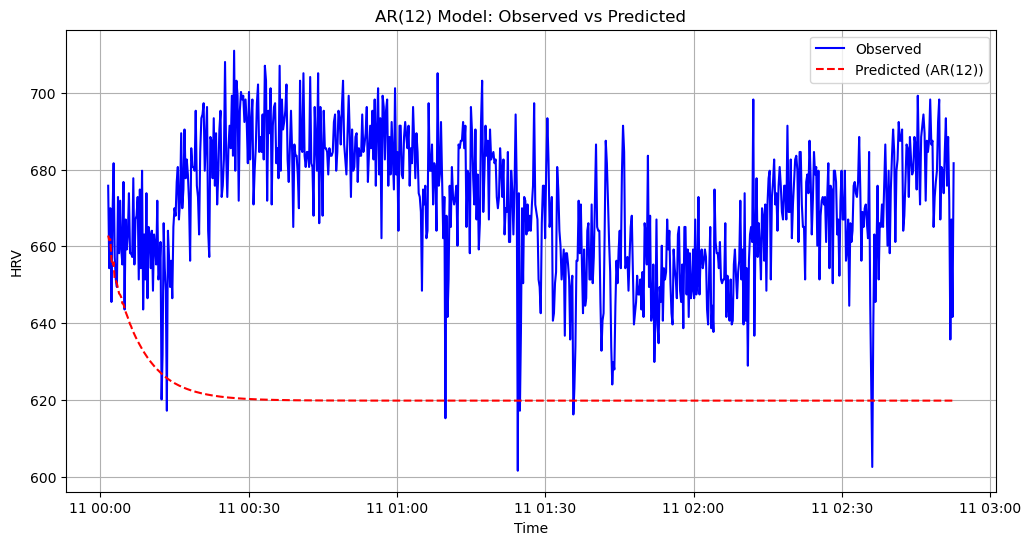

In [17]:
# plot observed versus predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['HRV'], 'b-', label='Observed')
plt.plot(pred_data.index, pred_data['pred HRV'], 'r--', label='Predicted (AR(12))')
plt.legend()
plt.title('AR(12) Model: Observed vs Predicted')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.grid(True)
plt.show()

In [18]:
# compute mae and rmse
mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 49.54
Root Mean Squared Error: 52.91


For the stationarity assumption to be met, the absolute value of the roots should be greater than 1. In general, based on the roots from above, all of the values are greater than 1. Therefore, it can be said that the stationarity assumption is met.

# Creating order features for MA model

In [19]:
# getting every 20 samples - downsampling because there are too many samples
df_downsampled = df_patient_hr.iloc[::20]
df_downsampled

# get order features 1-17
for i in range(1, 18):
    df_downsampled[f'Order {i}'] = df_downsampled['HRV'].shift(i)

df_downsampled = df_downsampled.dropna()

df_downsampled.head()

,HRV,Order 1,Order 2,Order 3,Order 4,Order 5,Order 6,Order 7,Order 8,Order 9,Order 10,Order 11,Order 12,Order 13,Order 14,Order 15,Order 16,Order 17
TIMESTAMP,,,,,,,,,,,,,,,,,,
2011-05-10 13:31:00.918,323.24,612.30,452.15,527.34,528.32,507.81,456.05,296.88,914.06,477.54,1200.20,1013.67,2000.00,2000.00,2000.00,860.35,2000.00,5000.00
2011-05-10 13:31:11.860,673.83,323.24,612.30,452.15,527.34,528.32,507.81,456.05,296.88,914.06,477.54,1200.20,1013.67,2000.00,2000.00,2000.00,860.35,2000.00
2011-05-10 13:31:21.715,515.63,673.83,323.24,612.30,452.15,527.34,528.32,507.81,456.05,296.88,914.06,477.54,1200.20,1013.67,2000.00,2000.00,2000.00,860.35
2011-05-10 13:31:29.234,351.56,515.63,673.83,323.24,612.30,452.15,527.34,528.32,507.81,456.05,296.88,914.06,477.54,1200.20,1013.67,2000.00,2000.00,2000.00
2011-05-10 13:31:39.107,239.26,351.56,515.63,673.83,323.24,612.30,452.15,527.34,528.32,507.81,456.05,296.88,914.06,477.54,1200.20,1013.67,2000.00,2000.00


# Split data into training and testing data for MA model

In [20]:
# split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
train_size = int(.8 * len(df_downsampled))
train_data = df_downsampled[:train_size]
test_data = df_downsampled[train_size:]

# put the y feature in arrays
y_train = np.array(train_data['HRV']).reshape(-1,1)
y_test = np.array(test_data['HRV']).reshape(-1,1)

# MA model

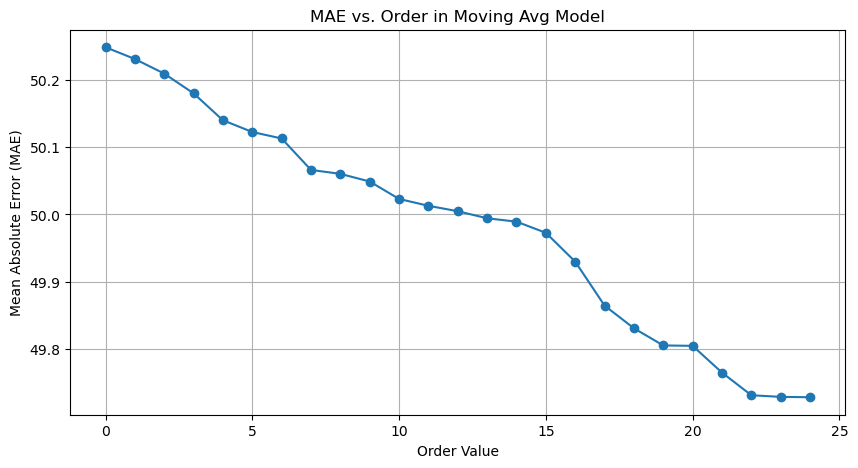

In [21]:
# define a range of orders to test
o_values = range(0, 25)
mae_scores = []

# loop through different order values
for o in o_values:
    # test different orders
    ma_model = ARIMA(y_train, order=(0,0,o))
    ma_results = ma_model.fit()
    
    # make predictions
    pred_data = ma_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # compute MAE
    mae = mean_absolute_error(y_test, pred_data)
    mae_scores.append(mae)

# plot MAE vs Lag
plt.figure(figsize=(10, 5))
plt.plot(o_values, mae_scores, marker='o', linestyle='-')
plt.xlabel("Order Value")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("MAE vs. Order in Moving Avg Model")
plt.grid(True)
plt.show()

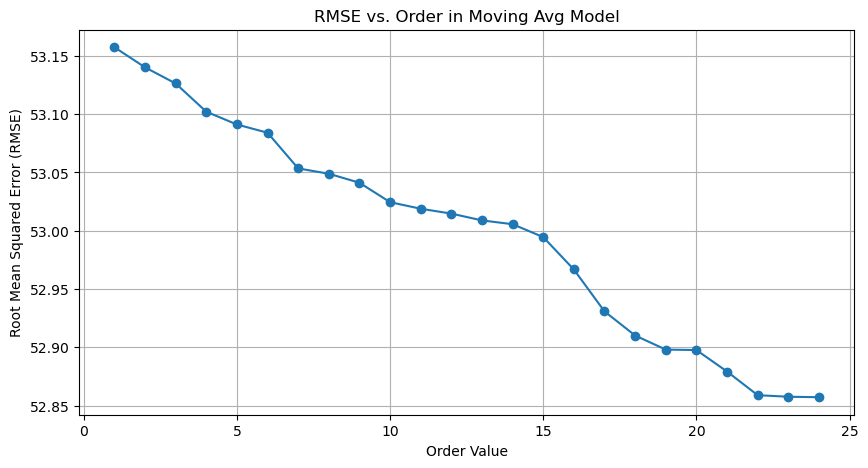

In [22]:
# define a range of orders to test
o_values = range(1, 25)
rmse_scores = []

# loop through different order values
for o in o_values:
    # test different order values
    ma_model = ARIMA(y_train, order=(0,0,o))
    ma_results = ma_model.fit()
    
    # make predictions
    pred_data = ma_results.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)
    
    # compute rmse
    rmse = np.sqrt(mean_squared_error(y_test, pred_data))
    rmse_scores.append(rmse)


# plot MAE vs order
plt.figure(figsize=(10, 5))
plt.plot(o_values, rmse_scores, marker='o', linestyle='-')
plt.xlabel("Order Value")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("RMSE vs. Order in Moving Avg Model")
plt.grid(True)
plt.show()

## Manually

In [23]:
# calculate the error terms (residuals)
def ma_errors(params, y, q):
    """
    Calculate residuals for MA(q) model with intercept
    params: first element is intercept, remaining elements are theta parameters (MA coefficients)
    y: observed values
    q: order of the MA model
    """
    # define variables
    intercept = params[0]  
    theta = params[1:]  
    n = len(y)
    errors = np.zeros(n)
    
    # initialize past errors
    past_errors = np.zeros(q)
    
    # calculate errors
    for t in range(n):
        # make prediction
        prediction = intercept + np.sum(theta * past_errors)
        errors[t] = y[t] - prediction
        # shift right
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = errors[t]
        
    return errors

# calculate the log-likelihood for MA(q) model
def ma_log_likelihood(params, y, q):
    """
    Calculate the log-likelihood for MA(q) model with intercept
    params: first element is intercept, remaining elements are theta parameters (MA coefficients)
    y: observed values
    q: order of the MA model
    """
    # define variables
    intercept = params[0]
    theta = params[1:]
    n = len(y)
    errors = np.zeros(n)
    past_errors = np.zeros(q)
    
    # calculate errors
    for t in range(n):
        # make prediction
        prediction = intercept + np.sum(theta * past_errors)
        errors[t] = y[t] - prediction
        # shift right
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = errors[t]
    
    # calculate log-likelihood (assuming errors are normally distributed)
    sigma2 = np.var(errors)  # Estimate of error variance
    log_likelihood = -0.5 * n * np.log(2 * np.pi * sigma2) - 0.5 * np.sum(errors**2) / sigma2
    
    return -log_likelihood

# fit MA model using MLE
def fit_ma_mle(y_train, q):
    """
    Fit MA(q) model with intercept using Maximum Likelihood Estimation
    y_train: training data for y
    q: order of the model
    """
    # initialize parameters (intercept and theta parameters)
    initial_intercept = np.mean(y_train)
    initial_theta = np.zeros(q)
    initial_params = np.concatenate(([initial_intercept], initial_theta))
    
    # use optimization to find the best parameters
    result = optimize.minimize(ma_log_likelihood, initial_params, args=(y_train, q,), 
                             method='L-BFGS-B')
    return result.x

# predict using MA model
def predict_ma(params, y_test_len, training_errors, q):
    """
    Make predictions using MA(q) model with intercept
    params: first element is intercept, remaining elements are theta parameters
    y_test_len: number of steps to predict
    training_errors: last q error terms from training data
    q: order of the model
    """
    # define intercept and theta
    intercept = params[0]
    theta = params[1:]
    
    # initialize predictions array
    predictions = np.zeros(y_test_len)
    # start with last q error terms from training
    past_errors = np.array(training_errors[:q])
    
    for t in range(y_test_len):
        # predictions
        predictions[t] = intercept + np.sum(theta * past_errors)
        new_error = 0
        # shift right
        past_errors = np.roll(past_errors, 1)
        past_errors[0] = new_error
        
    return predictions

# fit MA(q) and make predictions
def run_ma_model_mle(train_data, test_data, q):
    # Convert Series to numpy arrays
    y_train = np.array(train_data['HRV'])
    
    # fit MA(q) model with intercept using MLE
    params = fit_ma_mle(y_train, q)
    intercept = params[0]
    theta = params[1:]
    
    # print coefficients
    print("Coefficients:")
    print(f"Intercept: {intercept:.6f}")
    for i, coef in enumerate(theta):
        print(f"MA({i+1}): {coef:.6f}")
    
    # calculate errors from training data
    training_errors = ma_errors(params, y_train, q)
    
    # make predictions
    y_pred = predict_ma(params, len(test_data), training_errors, q)
    
    # put predictions into dataframe format
    pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': y_pred})
    pred_data.set_index('Time', inplace=True)
    
    return pred_data, params

In [24]:
# order chosen
order = 17

# run ma model
pred_data, theta = run_ma_model_mle(train_data, test_data, order)
pred_data.head()

Coefficients:
Intercept: 620.550465
MA(1): 0.489918
MA(2): 0.441031
MA(3): 0.537237
MA(4): 0.555015
MA(5): 0.447088
MA(6): 0.350149
MA(7): 0.413862
MA(8): 0.194870
MA(9): 0.254062
MA(10): 0.287168
MA(11): 0.190334
MA(12): 0.228322
MA(13): 0.247611
MA(14): 0.212633
MA(15): 0.227604
MA(16): 0.205039
MA(17): 0.141425


,pred HRV
Time,
2011-05-11 00:01:47.940,609.657571
2011-05-11 00:02:01.230,558.375833
2011-05-11 00:02:14.396,452.228192
2011-05-11 00:02:27.557,470.420671
2011-05-11 00:02:40.901,490.074471


In [25]:
# function to get roots for ma model
def find_ma_roots(ma_coeffs):
    # create the polynomial coefficients (note the negative sign for MA coeffs)
    poly_coeffs = np.concatenate([[1], -1 * ma_coeffs])
    
    # find the roots
    roots = np.roots(poly_coeffs)
    
    return roots

# coefficients of the ma model
ma_coeffs = theta[1:]

# roots of the ma model
roots = find_ma_roots(ma_coeffs)
print(abs(roots))

[1.46215762 0.91437574 0.91437574 0.89225537 0.89225537 0.88598943
 0.88598943 0.86275161 0.86275161 0.88953642 0.88953642 0.82880478
 0.82880478 0.85898662 0.85898662 0.78747321 0.78747321]


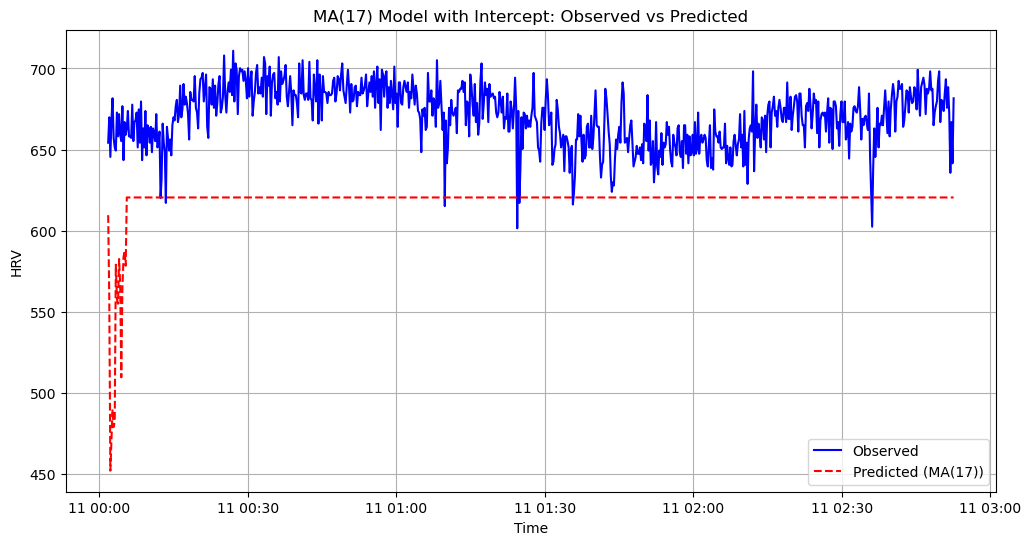

In [26]:
# plot observed versus predicted
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['HRV'], 'b-', label='Observed')
plt.plot(pred_data.index, pred_data['pred HRV'], 'r--', label='Predicted (MA(17))')
plt.legend()
plt.title('MA(17) Model with Intercept: Observed vs Predicted')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.grid(True)
plt.show()

In [27]:
mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 52.00
Root Mean Squared Error: 56.18
